### Build and test a Naive Bayes classifier.

We will again use the iris data. In case you don't feel familiar with the iris varieties yet, here are some pictures. The petals are smaller and stick out above the larger, flatter sepals. In many flowers, the sepal is a greenish support below the petals, but the iris sepals are designed specifically as landing pads for bumblebees, and the bright yellow coloring on the sepal directs the bees down into the tight space where pollination happens.

<img src="../Extra/iris.jpg">

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_iris
from sklearn.naive_bayes import BernoulliNB

In [2]:
# Load the data, which is included in sklearn.
iris = load_iris()
print 'Iris target names:', iris.target_names
print 'Iris feature names:', iris.feature_names
X, Y = iris.data, iris.target

# Shuffle the data, but make sure that the features and accompanying labels stay in sync.
np.random.seed(0)
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

# Split into train and test.
train_data, train_labels = X[:100], Y[:100]
test_data, test_labels = X[100:], Y[100:]

Iris target names: ['setosa' 'versicolor' 'virginica']
Iris feature names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


The iris feature values are real valued -- measurements in centimeters. Let's look at histograms of each feature.

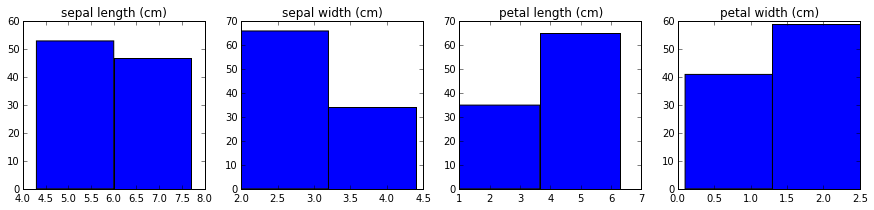

In [4]:
# Create a new figure and set the figsize argument so we get square-ish plots of the 4 features.
plt.figure(figsize=(15, 3))

# Iterate over the features, creating a subplot with a histogram for each one.
for feature in range(train_data.shape[1]):
    plt.subplot(1, 4, feature+1)
    plt.hist(train_data[:,feature], 2)
    plt.title(iris.feature_names[feature])

To make things simple, let's binarize these feature values. That is, we'll treat each measurement as either "short" or "long". I'm just going to choose a threshold for each feature.  Binning usually depends on the distribution.  There are two ways to bin data: constant bin width and constant bin size. For now let's just go with the two.

In [5]:
# Define a function that applies a threshold to turn real valued iris features into 0/1 features.
# 0 will mean "short" and 1 will mean "long".
def binarize_iris(data, thresholds=[6.0, 3.0, 2.5, 1.0]):
    # Initialize a new feature array with the same shape as the original data.
    binarized_data = np.zeros(data.shape)

    # Apply a threshold  to each feature.
    for feature in range(data.shape[1]):
        binarized_data[:,feature] = data[:,feature] > thresholds[feature]
    return binarized_data

# Create new binarized training and test data
binarized_train_data = binarize_iris(train_data)
binarized_test_data = binarize_iris(test_data)


Recall that Naive Bayes assumes conditional independence of features. With $Y$ the set of labels and $X$ the set of features ($y$ is a specific label and $x$ is a specific feature), Naive Bayes gives the probability of a label $y$ given input features $X$ as:

$ \displaystyle P(y|X) \approx 
  \frac { P(y) \prod_{x \in X} P(x|y) }
        { \sum_{y \in Y} P(y) \prod_{x \in X} P(x|y) }
$

Let's estimate some of these probabilities using maximum likelihood, which is just a matter of counting and normalizing. We'll start with the prior probability of the label $P(y)$.

In [6]:
# Initialize counters for all labels to zero.
label_counts = [0 for i in iris.target_names]
#  print label_counts
print iris.target_names

# Iterate over labels in the training data and update counts.
for label in train_labels:
    label_counts[label] += 1
print label_counts

# Normalize counts to get the estimates of the probabilities of each label.
total = sum(label_counts)
print total
label_probs = [1.0 * count / total for count in label_counts]
for (prob, name) in zip(label_probs, iris.target_names):
    print '%15s : %.2f' %(name, prob)    

['setosa' 'versicolor' 'virginica']
[31, 33, 36]
100
         setosa : 0.31
     versicolor : 0.33
      virginica : 0.36


Example of what zip() function does (from https://docs.python.org/2/library/functions.html#zip):             

In [17]:
x = [1, 2, 3]
y = [4, 5, 6]
zipped = zip(x, y)
zipped

[(1, 4), (2, 5), (3, 6)]

Now, we have estimated the prior probabilities of each label, $P(y)$

Next, let's estimate $P(X|Y)$, that is, the probability of each feature given each label: if I am a flower labeled $y (e.g., setosa)$, what is the probability that my measurements (features) will be $x$?  

Remember that we can get the conditional probability from the joint distribution:

$\displaystyle P(X|Y) = \frac{ P(X,Y) } { P(Y) } \approx \frac{ \textrm{Count}(X,Y) } { \textrm{Count}(Y) }$

Let's think carefully about the size of the count matrix we need to collect. There are 3 labels $y_1$, $y_2$, and $y_3$ ($setosa$, $versicolor$, and $virginica$) and 4 features $x_0$, $x_1$, $x_2$, and $x_3$ ($petalLength$, $petalWidth$, $sepalLength$, and $sepalWidth$). Each feature has 2 possible values, 0 or 1. So there are actually $4 \times 2 \times 3=24$ probabilities we need to estimate: 

$P(x_0=0, Y=y_0)$

$P(x_0=1, Y=y_0)$

$P(x_1=0, Y=y_0)$

$P(x_1=1, Y=y_0)$

...

However, we already estimated (above) the probability of each label, $P(y)$. And, we know that each feature value is either 0 or 1. So, for example,

$P(x_0=0, Y=\textrm{setosa}) + P(x_0=1, Y=\textrm{setosa}) = P(Y=\textrm{setosa}) \approx 0.31$.

As a result, we can just estimate probabilities for one of the feature values, say, $x_i = 0$. This requires a $4 \times 3$ matrix.

In [7]:
# Initialize a matrix for joint counts of feature=0 and label.
feature0_and_label_counts = np.zeros([len(iris.feature_names), len(iris.target_names)])

# Just to check our work, let's also keep track of joint counts of feature=1 and label.
feature1_and_label_counts = np.zeros([len(iris.feature_names), len(iris.target_names)])

for i in range(binarized_train_data.shape[0]):
    # Pick up one training example at a time: a label and a feature vector.
    label = train_labels[i]
    features = binarized_train_data[i]
    
    # Update the count matrices.
    for feature_index, feature_value in enumerate(features):
        feature0_and_label_counts[feature_index][label] += (feature_value == 0)
        feature1_and_label_counts[feature_index][label] += (feature_value == 1)

# Let's look at the counts.
print 'Feature = 0 and label:\n', feature0_and_label_counts
print '\nFeature = 1 and label:\n', feature1_and_label_counts

# As a sanity check, what should the total sum of all counts be?
# We have 100 training examples, each with 4 features. So we should have counted 400 things.
total_sum = feature0_and_label_counts.sum() + feature1_and_label_counts.sum()
print '\nTotal count:', total_sum

# As another sanity check, the label probabilities should be equal to the normalized feature counts for each label.
print 'Label probabilities:', (feature0_and_label_counts.sum(0) + feature1_and_label_counts.sum(0)) / total_sum

Feature = 0 and label:
[[ 31.  20.   7.]
 [  6.  27.  25.]
 [ 31.   0.   0.]
 [ 31.   3.   0.]]

Feature = 1 and label:
[[  0.  13.  29.]
 [ 25.   6.  11.]
 [  0.  33.  36.]
 [  0.  30.  36.]]

Total count: 400.0
Label probabilities: [ 0.31  0.33  0.36]


We still need to normalize the joint counts to get probabilities.

In [8]:
# Initialize new matrices to hold conditional probabilities.
feature0_given_label = np.zeros(feature0_and_label_counts.shape)
feature1_given_label = np.zeros(feature1_and_label_counts.shape)

# P(feature|label) = P(feature, label) / P(label) =~ count(feature, label) / count(label).
# Note that we could do this normalization more efficiently with array operations, but for the sake of clarity,
# let's iterate over each label and each feature.
for label in range(feature0_and_label_counts.shape[1]):
    for feature in range(feature0_and_label_counts.shape[0]):
        feature0_given_label[feature,label] = feature0_and_label_counts[feature,label] / label_counts[label]
        feature1_given_label[feature,label] = feature1_and_label_counts[feature,label] / label_counts[label]

# Here's our estimated conditional probability table.
print 'Estimated values of P(feature=0|label):\n', feature0_given_label

# As a sanity check, which probabilities should sum to 1?
print '\nCheck that P(feature=0|label) + P(feature=1|label) = 1\n',feature0_given_label + feature1_given_label

Estimated values of P(feature=0|label):
[[ 1.          0.60606061  0.19444444]
 [ 0.19354839  0.81818182  0.69444444]
 [ 1.          0.          0.        ]
 [ 1.          0.09090909  0.        ]]

Check that P(feature=0|label) + P(feature=1|label) = 1
[[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]


Now that we have all the pieces, let's try making a prediction for the first test example. It looks like this is a setosa (label 0) example with all small measurements -- all the feature values are 0.

We start by assuming the prior distribution, which has a slight preference for virginica, followed by versicolor. Of course, these estimates come from our training data, which might not be a representative sample. In practice, we may prefer to use a uniform prior.

In [9]:
# What does the feature vector look like? And what's the true label?
index = 0
print 'Feature vector:', binarized_test_data[index]
print 'Label:', test_labels[index]

# Start with the prior distribution over labels.
predictions = label_probs[:]
print 'Prior:', predictions

Feature vector: [ 0.  0.  0.  0.]
Label: 0
Prior: [0.31, 0.33, 0.36]


You can think of each feature as an additional piece of evidence. After observing the first feature, we update our belief by multiplying our initial probabilities by the probability of the observation, conditional on each possible label.

In [10]:
# Let's include the first feature. We use feature0_given_label since the feature value is 0.
predictions *= feature0_given_label[0]

# We could wait until we've multiplied by all the feature probabilities, but there's no harm in normalizing after each update.
predictions /= predictions.sum()
print 'After observing sepal length:', predictions

After observing sepal length: [ 0.53448276  0.34482759  0.12068966]


So after observing a short sepal, our updated belief prefers setosa. Let's include the remaining observations.

In [11]:
# Include the second feature.
predictions *= feature0_given_label[1]
predictions *= feature0_given_label[2]
predictions *= feature0_given_label[3]

# We could wait until we've multiplied by all the feature probabilities, but there's no harm in normalizing after each update.
predictions /= predictions.sum()
print 'After observing all features:', predictions

After observing all features: [ 1.  0.  0.]


What happened?

Well, it looks like Naive Bayes came up with the right answer. But it seems overconfident!

Let's look again at our conditional probability estimates for the features. Notice that there are a bunch of zero probabilities. This is bad because as soon as we multiply anything by zero, we're guaranteed that our final estimate will be zero. This is an overly harsh penalty for an observation that simply never occurred in our training data. Surely there's some possibility, even if very small, that there could exist a setosa with a long sepal.

This is where smoothing comes in. The maximum likelihood estimate is only optimal in the case where we have infinite training data. When we have less than that, we need to temper maximum likelihood by reserving some small probability for unseen events. The simplest way to do this is with Laplace smoothing -- rather than starting with a count of 0 for each joint (feature, label) observation, we start with a count of $\alpha$.

Let's package training and inference into a class, modeled after sklearn's BernoulliNB.

In [11]:
class NaiveBayes:
    # Initialize an instance of the class.
    def __init__(self, alpha=1.0):
        self.alpha = alpha     # additive (Laplace) smoothing parameter
        self.priors = None     # estimated by fit()
        self.probs = None      # estimated by fit()
        self.num_labels = 0    # set by fit()
        self.num_features = 0  # set by fit()
        
    def fit(self, train_data, train_labels):
        # Store number of labels, number of features, and number training examples.
        self.num_labels = len(np.unique(train_labels))
        self.num_features = train_data.shape[1]
        self.num_examples = train_data.shape[0]
        
        # Initialize an array of label counts. Each label gets a smoothed count of 2*alpha because
        # each feature value (0 and 1) gets an extra count of alpha.
        label_counts = np.ones(self.num_labels) * self.alpha * 2

        # Initialize an array of (feature=1, label) counts to alpha.
        feature0_and_label_counts = np.ones([self.num_features, self.num_labels]) * self.alpha
        
        # Count features with value == 1.
        for i in range(self.num_examples):
            label = train_labels[i]
            label_counts[label] += 1
            for feature_index, feature_value in enumerate(train_data[i]):
                feature0_and_label_counts[feature_index][label] += (feature_value == 1)

        # Normalize to get probabilities P(feature=1|label).
        self.probs = feature0_and_label_counts / label_counts
        
        # Normalize label counts to get prior probabilities P(label).
        self.priors = label_counts / label_counts.sum()

    # Make predictions for each test example and return results.
    def predict(self, test_data):
        results = []
        for item in test_data:
            results.append(self._predict_item(item))
        return np.array(results)
    
    # Private function for making a single prediction.
    def _predict_item(self, item):
        # Make a copy of the prior probabilities.
        predictions = self.priors.copy()
        
        # Multiply by each conditional feature probability.
        for (index, value) in enumerate(item):
            feature_probs = self.probs[index]
            if not value: feature_probs = 1 - feature_probs
            predictions *= feature_probs

        # Normalize and return the label that gives the largest probability.
        predictions /= predictions.sum()
        return predictions.argmax()

Now we can compare our implementation with the sklearn implementation. Do the predictions agree? What about the estimated parameters? Try changing alpha from 0 to 1.

Note: I think there might be a bug in the sklearn code. What do you think?

In [13]:
alpha = 0
nb = NaiveBayes(alpha=alpha)
nb.fit(binarized_train_data, train_labels)

# Compute accuracy on the test data.
preds = nb.predict(binarized_test_data)
correct, total = 0, 0
for pred, label in zip(preds, test_labels):
    if pred == label: correct += 1
    total += 1
print 'With alpha = %.2f' %alpha
print '[OUR implementation] total: %3d  correct: %3d  accuracy: %3.2f' %(total, correct, 1.0*correct/total)

# Compare to sklearn's implementation.
clf = BernoulliNB(alpha=alpha)
clf.fit(binarized_train_data, train_labels)
print 'sklearn accuracy: %3.2f' %clf.score(binarized_test_data, test_labels)

print '\nOur feature probabilities\n', nb.probs
print '\nsklearn feature probabilities\n', np.exp(clf.feature_log_prob_).T

print '\nOur prior probabilities\n', nb.priors
print '\nsklearn prior probabilities\n', np.exp(clf.class_log_prior_)

With alpha = 0.00
[OUR implementation] total:  50  correct:  41  accuracy: 0.82
sklearn accuracy: 0.52

Our feature probabilities
[[ 0.          0.39393939  0.80555556]
 [ 0.80645161  0.18181818  0.30555556]
 [ 0.          1.          1.        ]
 [ 0.          0.90909091  1.        ]]

sklearn feature probabilities
[[ 0.          0.39393939  0.80555556]
 [ 0.80645161  0.18181818  0.30555556]
 [ 0.          1.          1.        ]
 [ 0.          0.90909091  1.        ]]

Our prior probabilities
[ 0.31  0.33  0.36]

sklearn prior probabilities
[ 0.31  0.33  0.36]
